In [16]:
import os
import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import colors as mcolors
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import seaborn as sn  

import warnings
warnings.filterwarnings('ignore')

In [11]:
import seaborn as sns
class Analisis_Predictivo:

    def __init__(self,datos:DataFrame, predecir:str, predictoras = [],
                 modelo = None,train_size = 75,random_state = None):
        '''
        datos: Datos completos y listos para construir un modelo
        
        modelo: Instancia de una Clase de un método de clasificación(KNN,Árboles,SVM,etc).
        Si no especifica un modelo no podrá utilizar el método fit_n_review()
        
        predecir: Nombre de la variable a predecir
        
        predictoras: Lista de los nombres de las variables predictoras.
        Si vacío entonces utiliza todas las variables presentes excepto la variable a predecir.
        
        train_size: Proporción de la tabla de entrenamiento respecto a la original.
        
        random_state: Semilla aleatoria para la división de datos(training-testing).
        '''        
        self.datos = datos
        self.predecir = predecir
        self.predictoras = predictoras
        self.modelo = modelo
        self.random_state = random_state
        if modelo != None:
            self.train_size = train_size
            self._training_testing()
        
        
    def _training_testing(self):
        if len(self.predictoras) == 0:
            X = self.datos.drop(columns=[self.predecir])
        else:
            X = self.datos[self.predictoras]
            
        y = self.datos[self.predecir].values
        
        train_test = train_test_split(X, y, train_size=self.train_size, 
                                      random_state=self.random_state)
        self.X_train, self.X_test,self.y_train, self.y_test = train_test
        
        
    def fit_predict(self):
        if(self.modelo != None):
            self.modelo.fit(self.X_train,self.y_train)
            return self.modelo.predict(self.X_test)
        
    def fit_predict_resultados(self, imprimir = True):
        if(self.modelo != None):
            y = self.datos[self.predecir].values
            prediccion = self.fit_predict()
            MC = confusion_matrix(self.y_test, prediccion)
            indices = self.indices_general(MC,list(np.unique(y)))
            if imprimir == True:
                for k in indices:
                    print("\n%s:\n%s"%(k,str(indices[k])))
            
            return indices
    
    def indices_general(self,MC, nombres = None):
        "Método para calcular los índices de calidad de la predicción"
        precision_global = np.sum(MC.diagonal()) / np.sum(MC)
        error_global = 1 - precision_global
        precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
        if nombres!=None:
            precision_categoria.columns = nombres
        return {"Matriz de Confusión":MC, 
                "Precisión Global":precision_global, 
                "Error Global":error_global, 
                "Precisión por categoría":precision_categoria}
    
    def distribucion_variable_predecir(self):
        "Método para graficar la distribución de la variable a predecir"
        variable_predict = self.predecir
        data = self.datos
        colors = list(dict(**mcolors.CSS4_COLORS))
        df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
        fig = plt.figure(figsize=(10,9))
        g = fig.add_subplot(111)
        countv = 0
        titulo = "Distribución de la variable %s" % variable_predict
        for i in range(df.shape[0]):
            g.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
            countv = countv + df.iloc[i]
        vals = g.get_xticks()
        g.set_xlim(0,1)
        g.set_yticklabels("")
        g.set_title(titulo)
        g.set_ylabel(variable_predict)
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        countv = 0 
        for v in df.iloc[:,0]:
            g.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        
    def poder_predictivo_categorica(self, var:str):
        "Método para ver la distribución de una variable categórica respecto a la predecir"
        data = self.datos
        variable_predict = self.predecir
        df = pd.crosstab(index= data[var],columns=data[variable_predict])
        df = df.div(df.sum(axis=1),axis=0)
        titulo = "Distribución de la variable %s según la variable %s" % (var,variable_predict)
        g = df.plot(kind='barh',stacked=True,legend = True, figsize = (10,9), \
                    xlim = (0,1),title = titulo, width = 0.8)
        vals = g.get_xticks()
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        for bars in g.containers:
            plt.setp(bars, width=.9)
        for i in range(df.shape[0]):
            countv = 0 
            for v in df.iloc[i]:
                g.text(np.mean([countv,countv+v]) - 0.03, i , '{:.1%}'.format(v), color='black', fontweight='bold')
                countv = countv + v
                
                
    def poder_predictivo_numerica(self,var:str):
        "Función para ver la distribución de una variable numérica respecto a la predecir"
        sns.FacetGrid(self.datos, hue=self.predecir, height=6).map(sns.kdeplot, var, shade=True).add_legend()
        
        
        

#Para utilizar independientemente de la clase
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":precision_global, 
            "Error Global":error_global, 
            "Precisión por categoría":precision_categoria}

# Ejercicio 1: [__20 pts__] Para este ejercicio usaremos la tabla de datos `potabilidad_V2.csv`, que contiene diferentes métricas de calidad del agua para cuerpos de agua distintos. Para esta tabla, las 9 primeras columnas corresponden a las variables predictoras y la variable `Potability` es la variable a predecir, la cual indica si el agua es segura para el consumo humano o no.

La tabla contiene 2011 filas (individuos) y 10 columnas (variables), las cuales se explican a continuación.

+ `ph`: Indica la acidez o alcalinidad del estado del agua.
+ `Hardness`: Dureza, es la concentración de compuestos minerales que hay en una determinada cantidad de agua.
+ `Solids`: Sólidos disueltos totales (TDS), es una medida de la cantidad de material disuelto en el agua.
+ `Chloramines`: Cloraminas, se producen cuando el amoníaco y el cloro (en forma de ácido hipocloroso) reaccionan entre sí.
+ `Sulfate`: Concentración de sulfato en el agua.
+ `Conductivity`: Conductividad, medida de la capacidad del agua para conducir la electricidad.
+ `Organic_carbon`: Cantidad total de carbono en compuestos orgánicos del agua.
+ `Trihalomethanes`: Trihalometanos, concentración de THM en el agua.
+ `Turbidity`: Turbidez, medida de las propiedades emisoras de luz del agua.
+ `Potability`: (Si, No).


In [84]:
datos = pd.read_csv('datos/potabilidad_V2.csv',delimiter=',',decimal=".")
datos = datos.iloc[:,1:11]

## 1 . Usando el paquete `MLPClassifier` en `Python` genere modelos predictivos usando un 75 % de los datos para tabla aprendizaje y un 25% para la tabla testing. Genere al menos 2 modelos con configuraciones diferentes en los parámetros vistos en clase(hidden layer sizes, activation, solver). Realice lo anterior sin estandarizar los datos y luego con los datos estandarizados, es decir, al menos 4 modelos. Para estandarizar los datos utilice la clase `StandardScaler` de `sklearn.preprocessing`

## 2. Para cada modelo obtenga los índices de precisión, compare e interprete los resultados y las diferencias entre los modelos con datos estandarizados y los que no.

### __Sin estandarizar__

#### Modelo 1

In [86]:
print("====================relu===================")
nnet1 = MLPClassifier(hidden_layer_sizes= (60,30,20) , activation= "relu", random_state=0)

analisis1 = Analisis_Predictivo(datos,predecir= "Potability",modelo = nnet1, 
                                       train_size= 0.75, random_state=0)
resultados = analisis1.fit_predict_resultados()


====================relu===================

Matriz de Confusión:
[[ 11 298]
 [ 12 182]]

Precisión Global:
0.3836978131212724

Error Global:
0.6163021868787276

Precisión por categoría:
         No        Si
0  0.035599  0.938144


#### Modelo 2

In [80]:
print("\n====================tanh===================")
nnet2 = MLPClassifier(hidden_layer_sizes= (50,30,20) , activation= 'tanh', random_state=0)
analisis2 = Analisis_Predictivo(datos,predecir= "Potability",modelo = nnet2, 
                                       train_size= 0.75, random_state=0)
resultados2 = analisis2.fit_predict_resultados()


====================tanh===================

Matriz de Confusión:
[[309   0]
 [194   0]]

Precisión Global:
0.614314115308151

Error Global:
0.38568588469184895

Precisión por categoría:
    No   Si
0  1.0  0.0


### Estandarizando 

In [81]:
datos.iloc[:, 1:9] = StandardScaler().fit_transform(datos.iloc[:, 1:9])
datos

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,8.316766,0.564114,0.011687,0.583804,0.574378,-0.783962,1.227032,2.111652,0.844761,No
1,9.092223,-0.455653,-0.455835,-0.370947,-0.560480,-0.348429,-0.842154,-2.140399,0.135033,No
2,5.584087,-0.234614,0.790645,0.259104,-0.158911,-1.810063,-1.792340,-0.714423,-1.807366,No
3,10.223862,1.596951,0.790764,0.239248,1.467140,-1.770608,-0.170876,1.132494,-1.662163,No
4,8.635849,0.226606,-0.954313,-1.622878,-0.726179,0.595858,-0.599824,-0.224135,0.553348,No
...,...,...,...,...,...,...,...,...,...,...
2006,8.989900,0.584770,-0.693978,-0.528284,-0.492625,-0.447578,-1.341281,-0.705001,0.825626,Si
2007,6.702547,0.347964,-0.540564,0.362137,-0.697038,-1.205321,0.559422,-2.334474,-0.675183,Si
2008,11.491011,-3.100365,1.767503,1.343596,-1.803476,0.165656,0.546021,-1.545585,0.512125,Si
2009,6.069616,-0.285317,0.488576,0.387023,0.302843,-0.131852,-0.688929,-0.372108,-0.384562,Si


#### Modelo 1

In [82]:
print("\n====================identity===================")
nnet3 = MLPClassifier(hidden_layer_sizes= (60,30) , activation= "identity", random_state=0)

analisis3 = Analisis_Predictivo(datos,predecir= "Potability",modelo = nnet3, 
                                       train_size= 0.75, random_state=0)
resultados = analisis3.fit_predict_resultados()



====================identity===================

Matriz de Confusión:
[[308   1]
 [193   1]]

Precisión Global:
0.614314115308151

Error Global:
0.38568588469184895

Precisión por categoría:
         No        Si
0  0.996764  0.005155


#### Modelo 2

In [83]:
print("\n====================logistic===================")
nnet4 = MLPClassifier(hidden_layer_sizes= (60,30) , activation= "logistic", random_state=0)
analisis4 = Analisis_Predictivo(datos,predecir= "Potability",modelo = nnet4, 
                                       train_size= 0.75, random_state=0)
resultados = analisis4.fit_predict_resultados()


====================logistic===================

Matriz de Confusión:
[[268  41]
 [123  71]]

Precisión Global:
0.6739562624254473

Error Global:
0.32604373757455274

Precisión por categoría:
         No        Si
0  0.867314  0.365979


Mejor modelo es con la función de activación `logistic`. Usar más o con menos nodos disminuye a la mitad la precisión global. Debido a que la tabla no tiene números con un rango mayo de 10 estandarizarlos apenas mejora el modelo

# Ejercicio 2: __[20 puntos]__ En este ejercicio vamos a usar la tabla de datos `wine.csv`, que contiene variantes del vino de la fabrica *Vinho Verde*. Los datos incluyen variables de pruebas fisicoquímicas y sensoriales realizadas a dicho vino.

La tabla contiene 1599 filas y 12 columnas, las cuales se explican a continuación.
+ `fija.acidez`: Acidez fija, ácidos presentes después de la destilación.
+ `volatil.acidez`: Acidez volátil, esta determina si el vino tendrá un sabor avinagrado. 
+ `citrica.acidez`: Acidez cítrica, esta es propiamente de las uvas y no por fermentación.
+ `residual.azucar`: Azúcar residual del vino que no fue fermentada.
+ `cloruros`: Cloruros, uno de los principales componentes salinos del vino.
+ `libre.sulfuro.dioxido`: Dióxido de azufre libre, antimicrobiano natural.
+ `total.sulfuro.dioxido`: Dióxido de azufre total, suma del dióxido libre y combinado. 
+ `densidad`: Densidad.
+ `pH`: Potencial de hidrógeno, este reduce la sensación de acidez en el vino.
+ `sulfitos`: Sulfitos, conservan los aromas y actúa como desinfectante.
+ `alcohol`: Alcohol presente.
+ `calidad`: Calidad del vino.
+ `tipo`: Tinto o Blanco (variable a predecir).

Realice lo siguiente:

In [124]:
datos = pd.read_csv('datos/wine.csv',delimiter=',',decimal=".")
datos

,fija.acidez,volatil.acidez,citrica.acidez,residual.azucar,cloruros,libre.sulfuro.dioxido,total.sulfuro.dioxido,densidad,pH,sulfitos,alcohol,calidad,tipo
0,6.2,0.30,0.21,1.1,0.032,31.0,111.0,0.98890,2.97,0.42,12.2,6,blanco
1,6.6,0.61,0.01,1.9,0.080,8.0,25.0,0.99746,3.69,0.73,10.5,5,tinto
2,6.4,0.32,0.23,16.2,0.055,36.0,176.0,0.99860,3.26,0.54,9.1,5,blanco
3,7.0,0.22,0.29,8.9,0.050,24.0,90.0,0.99556,3.29,0.46,9.8,6,blanco
4,6.4,0.43,0.27,1.1,0.054,5.0,110.0,0.99390,3.24,0.52,9.1,4,blanco
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,blanco
6493,6.4,0.26,0.43,12.6,0.033,64.0,230.0,0.99740,3.08,0.38,8.9,5,blanco
6494,6.2,0.25,0.48,10.0,0.044,78.0,240.0,0.99655,3.25,0.47,9.5,6,blanco
6495,7.2,0.60,0.20,9.9,0.070,21.0,174.0,0.99710,3.03,0.54,9.1,5,blanco


## 1. Usando el paquete `MLPClassifier` en `Python` genere modelos predictivos usando un 80 % de los datos para tabla aprendizaje y un 20% para la tabla testing. Genere al menos 2 modelos con configuraciones diferentes en los parámetros vistos en clase(hidden layer sizes, activation, solver). Realice lo anterior sin estandarizar los datos y luego con los datos estandarizados, es decir, al menos 4 modelos. Para estandarizar los datos utilice la clase `StandardScaler` de `sklearn.preprocessing`.


## 2. Para cada modelo obtenga los índices de precisión, compare e interprete los resultados y las diferencias entre los modelos con datos estandarizados y los que no.

### Sin estandarizar 

#### Modelo 1

In [125]:
print("====================relu===================")
nnet1 = MLPClassifier(hidden_layer_sizes= (60,30,20) , activation= "relu", random_state=0)
analisis1 = Analisis_Predictivo(datos,predecir= "tipo",modelo = nnet1, 
                                       train_size= 0.80, random_state=0)
resultados = analisis1.fit_predict_resultados()

====================relu===================

Matriz de Confusión:
[[974   3]
 [ 27 296]]

Precisión Global:
0.9769230769230769

Error Global:
0.023076923076923106

Precisión por categoría:
     blanco     tinto
0  0.996929  0.916409


#### Modelo 2

In [126]:
print("\n====================logistic===================")
nnet2 = MLPClassifier(hidden_layer_sizes= (60,30,20) , activation= "logistic", random_state=0)
analisis2 = Analisis_Predictivo(datos,predecir= "tipo",modelo = nnet2, 
                                       train_size= 0.8, random_state=0)
resultados = analisis2.fit_predict_resultados()


====================logistic===================

Matriz de Confusión:
[[974   3]
 [ 22 301]]

Precisión Global:
0.9807692307692307

Error Global:
0.019230769230769273

Precisión por categoría:
     blanco     tinto
0  0.996929  0.931889


### Estandarizando 

In [127]:
datos.iloc[:, 0:12] = StandardScaler().fit_transform(datos.iloc[:, 0:12])
datos

,fija.acidez,volatil.acidez,citrica.acidez,residual.azucar,cloruros,libre.sulfuro.dioxido,total.sulfuro.dioxido,densidad,pH,sulfitos,alcohol,calidad,tipo
0,-0.783214,-0.240949,-0.747613,-0.912936,-0.686076,0.026746,-0.083949,-1.933215,-1.545645,-0.747799,1.432308,0.207999,blanco
1,-0.474652,1.642132,-2.124013,-0.744778,0.684143,-1.269173,-1.605601,0.921601,2.932668,1.335613,0.006875,-0.937230,tinto
2,-0.628933,-0.119460,-0.609973,2.261042,-0.029513,0.308467,1.066137,1.301798,0.258120,0.058683,-1.167011,-0.937230,blanco
3,-0.166089,-0.726906,-0.197054,0.726602,-0.172244,-0.367664,-0.455515,0.287938,0.444716,-0.478971,-0.580068,0.207999,blanco
4,-0.628933,0.548730,-0.334694,-0.912936,-0.058059,-1.438205,-0.101642,-0.265683,0.133722,-0.075731,-1.167011,-2.082458,blanco
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,0.207999,blanco
6493,-0.628933,-0.483928,0.766426,1.504332,-0.657530,1.886106,2.021594,0.901590,-0.861459,-1.016626,-1.334709,-0.937230,blanco
6494,-0.783214,-0.544672,1.110526,0.957819,-0.343521,2.674926,2.198530,0.618110,0.195921,-0.411765,-0.831615,0.207999,blanco
6495,-0.011808,1.581387,-0.816433,0.936799,0.398680,-0.536697,1.030750,0.801538,-1.172452,0.058683,-1.167011,-0.937230,blanco


#### Modelo 1

In [130]:
print("\n====================identity===================")
nnet3 = MLPClassifier(hidden_layer_sizes= (60,30,20) , activation= "identity", random_state=0)
analisis3 = Analisis_Predictivo(datos,predecir= "tipo",modelo = nnet3, 
                                       train_size= 0.8, random_state=0)
resultados = analisis3.fit_predict_resultados()



====================identity===================

Matriz de Confusión:
[[976   1]
 [  4 319]]

Precisión Global:
0.9961538461538462

Error Global:
0.0038461538461538325

Precisión por categoría:
     blanco     tinto
0  0.998976  0.987616


#### Modelo 2

In [129]:
print("\n====================tanh===================")
nnet4 = MLPClassifier(hidden_layer_sizes= (60,30) , activation= "tanh", random_state=0)
analisis4 = Analisis_Predictivo(datos,predecir= "tipo",modelo = nnet4, 
                                       train_size= 0.8, random_state=0)
resultados = analisis4.fit_predict_resultados()


====================tanh===================

Matriz de Confusión:
[[976   1]
 [  3 320]]

Precisión Global:
0.9969230769230769

Error Global:
0.003076923076923088

Precisión por categoría:
     blanco     tinto
0  0.998976  0.990712


El mejor modelo es con la función de activación `tanh`, esto nos hace sentido ya que dicha función maneja de manera más fácil los datos negativos que obtuvimos al estandarizar, aumentar el número de capas o nodos no varió de manera significativa la precisión. Los mejores resultados son por poco más de un punto los que utilizan datos estandarizados.

# Ejercicio 3: __[20 pts]__  En este ejercicio vamos a predecir números escritos a mano (Hand Written Digit Recognition), la tabla de aprendizaje está en el archivo `ZipDataTrainCod.csv` y la tabla de testing está en el archivo `ZipDataTestCod.csv`. En la figura siguiente se ilustran los datos:

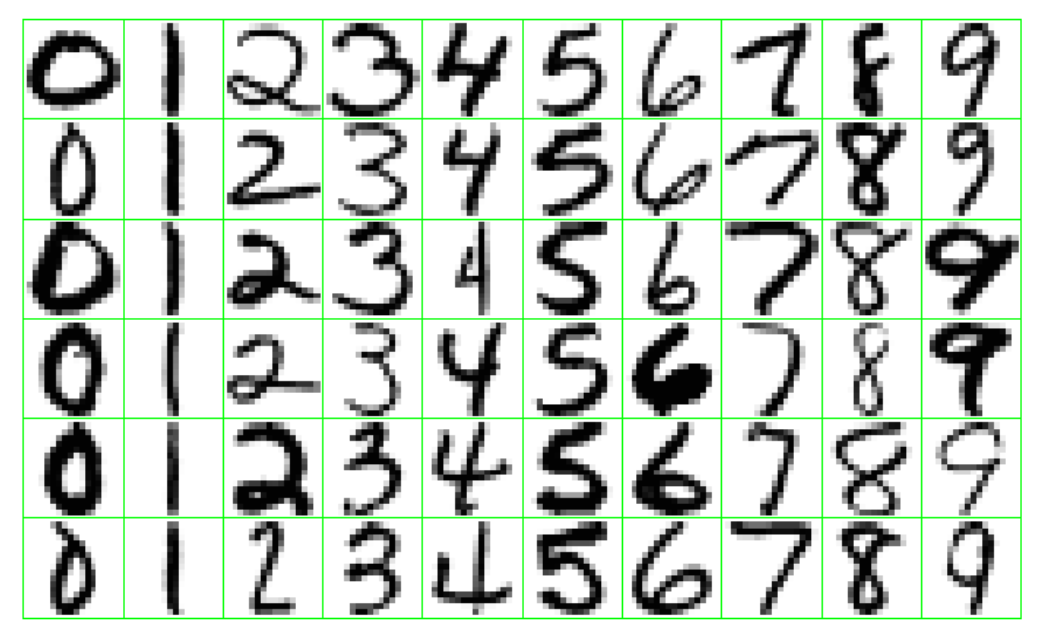

In [133]:
Image(filename='./zipdata.PNG')

In [4]:
train = pd.read_csv('datos/ZipDataTestCod.csv',delimiter=";",decimal=".")
test = pd.read_csv('datos/ZipDataTrainCod.csv',delimiter=";",decimal="." )

train

,Numero,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257
0,nueve,-1.0,-1.0,-1.0,-1.000,-1.000,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,seis,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,tres,-1.0,-1.0,-1.0,-0.593,0.700,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,seis,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,seis,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,tres,-1.0,-1.0,-1.0,-1.000,-1.000,-0.417,0.814,1.000,0.775,...,1.000,1.000,0.554,0.184,-0.484,-1.000,-1.0,-1.0,-1.0,-1.0
2003,nueve,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.855,0.209,0.941,...,-1.000,0.319,1.000,0.056,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2004,cuatro,-1.0,-1.0,-1.0,-1.000,-0.031,0.752,-0.431,-1.000,-1.000,...,1.000,0.928,-0.393,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2005,cero,-1.0,-1.0,-1.0,-1.000,-0.534,0.578,1.000,0.301,-0.328,...,1.000,0.430,0.200,-0.061,-0.975,-1.000,-1.0,-1.0,-1.0,-1.0


In [16]:
y_train = train["Numero"]
y_test = test["Numero"]

X_train = train.drop(labels = ["Numero"],axis = 1) 
X_test = test.drop(labels = ["Numero"],axis = 1)


## 1. Usando el paquete `MLPClassifier` en `Python` genere un modelo predictivo de redes neuronales para estos datos. Utilice los siguientes parámetros: `hidden_layer_sizes = (250,100,50,25)`, `max_iter = 50000`, `activation = ‘‘relu’’`, `solver = ‘‘adam’’`, `random state=0`.  Interprete los resultados.

In [205]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# vamos a pasar a forma one-hot-encoding 
y_train = y_train.astype('category')
y_test = y_test.astype('category')


In [206]:
nnet = MLPClassifier(hidden_layer_sizes= (250,100,50,25) , max_iter = 50000, 
                     activation = "relu", solver= "adam" ,random_state=0)

In [207]:
modelo = nnet.fit(X_train,y_train)
modelo_pred = nnet.predict(X_test)
MC = confusion_matrix(y_test, modelo_pred)
indices = indices_general(MC,list(np.unique(y_test)))

for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))
            



Matriz de Confusión:
[[1166    4    1   10    0    4    7    0    1    1]
 [   5  495    4    6    2    9   22    0   13    0]
 [   4    1  614    6    8    6    4    0    0    9]
 [   5    6    8  687    0   12    7    1    2    3]
 [   3    2   25    1  592    3    0   18    0    0]
 [   9    5    7    5    0  504    1    2    3    6]
 [  14    2    2    4    0    2  631    0    0    9]
 [   1    4    2    2   23    3    0  607    1    2]
 [   1   16    0   16    0   22    0    6  595    2]
 [   0    1    0    1    0    1    0    0    0 1002]]

Precisión Global:
0.94541215196818

Error Global:
0.05458784803182004

Precisión por categoría:
       cero     cinco    cuatro       dos     nueve      ocho      seis  \
0  0.976549  0.890288  0.941718  0.939808  0.919255  0.929889  0.950301   

      siete      tres       uno  
0  0.941085  0.904255  0.997015  


## 2. Genere un modelo de redes neuronales con los mismos parámetros del ítem anterior, pero esta vez reemplace cada bloque 4 × 4 de píxeles por su promedio. ¿Mejora la predicción? ¿Qué ventaja tiene estos datos respecto a los anteriores? Recuerde que cada bloque 16×16 está representado por una fila en las matrices de aprendizaje y testing. Despliegue la matriz de confusión resultante. La matriz de confusión obtenida debería ser igual o muy similar a esta:

In [41]:
def zipFila(fila, p = 4): #recibe una fila y un tam de pixel
    tam = 16
    row = []
    for n in range(0,len(fila),tam * p): # recorre toda la fila de 64 en 64
        bloques = []
        for m in range(0, tam, p): #recorre el bloque de 4 en 4 
            subBloque = []
            for i in range(p): # de 0 a 4
                inicio = m + (tam*i) + n
                fin = inicio + p
                subBloque += list(fila[inicio:fin])
            bloques += [np.mean(subBloque)]
            
        row += bloques
        
    return row

def zipFilaMax(fila, p = 4):
    tam = 16
    row = []
    for n in range(0,len(fila),tam * p):
        bloques = []
        for m in range(0, tam, p):
            subBloque = []
            for i in range(p):
                inicio = m + (tam*i) + n
                fin = inicio + p
                subBloque += list(fila[inicio:fin]) #toma 
            bloques += [np.max(subBloque)]
            
        row += bloques
        
    return row

def zipData(datos,p = 4):
    datosComprimidos = []
    for n in range(datos.shape[0]):
        datosComprimidos += [zipFila(datos.iloc[n,:],p)]
    
    return pd.DataFrame(datosComprimidos)


def zipDataMax(datos,p = 4):
    datosComprimidos = []
    for n in range(datos.shape[0]):
        datosComprimidos += [zipFilaMax(datos.iloc[n,:],p)]
    
    return pd.DataFrame(datosComprimidos)


In [56]:
df.iloc[0,:][0:4]

V2   -1.0
V3   -1.0
V4   -1.0
V5   -1.0
Name: 0, dtype: float64

In [22]:
df = X_train
colname = df.columns[0]
df_reduced = df.drop(columns = colname)#se deshace de la col V2 ??
new_df = pd.DataFrame(np.zeros((df_reduced.shape[0],16)))

for row in range(df_reduced.shape[0]):
    new_df.iloc[row,0]= df.loc[row,colname] # que la columna cero sea igual a la de la original
    start_row = 0
    ct = 1
    
    for col in range(0,df_reduced.shape[1],64) #da saltos de 64, osea estoy es como 3 (64,128,192,256)??
        
        for bloq in range(col,col+16,p) #va por cada col + 16 de 4 en 4, ??
        
            bloque = []
            start_row = bloq
            
            for skip in range(0,p):
                l=list(range(start_row,start_row + p))
                start_row += 16
                bloque.extend(l)
                
            media = df_reduced.iloc[row,bloque].mean(axis = 0)
            
            new_df.loc[row,ct]= media
            ct += 1
            
            
        
            

In [33]:
df

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257
0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.948,-0.561,0.148,0.384,0.904,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-0.593,0.700,1.000,1.000,1.000,1.000,0.853,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.858,-0.106,0.802,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,-1.0,-1.0,-1.0,-1.000,-1.000,-0.417,0.814,1.000,0.775,-0.723,...,1.000,1.000,0.554,0.184,-0.484,-1.000,-1.0,-1.0,-1.0,-1.0
2003,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.855,0.209,0.941,0.809,...,-1.000,0.319,1.000,0.056,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2004,-1.0,-1.0,-1.0,-1.000,-0.031,0.752,-0.431,-1.000,-1.000,-1.000,...,1.000,0.928,-0.393,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2005,-1.0,-1.0,-1.0,-1.000,-0.534,0.578,1.000,0.301,-0.328,-0.939,...,1.000,0.430,0.200,-0.061,-0.975,-1.000,-1.0,-1.0,-1.0,-1.0


### Promedio 

In [ ]:
X_test = zipData(test.drop(labels = ["Numero"],axis = 1))
X_train = zipData(train.drop(labels = ["Numero"],axis = 1))
modelo = nnet.fit(X_train,y_train)
modelo_pred = nnet.predict(X_test)
MC = confusion_matrix(y_test, modelo_pred)
indices = indices_general(MC,list(np.unique(y_test)))

for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))
            
X_test

In [43]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.000000,-0.474625,-0.375938,-1.000000,-0.821562,0.193125,-0.717812,-0.804563,-0.008250,-0.009563,0.027188,-0.051063,-0.576125,0.692063,0.627938,-0.785875
1,-0.859687,0.531687,0.310500,-0.038937,-0.833000,0.475688,0.214625,-0.871188,-0.000250,-0.895750,-0.811813,0.244750,-0.182938,0.228563,0.386750,0.313188
2,-1.000000,-0.987500,-0.138437,-0.937500,-0.733625,-0.354875,0.047500,-0.998563,-0.616125,0.111375,0.332375,-0.601938,-1.000000,-0.900687,0.170062,-1.000000
3,-0.869625,0.109813,0.074312,-0.647687,-0.667375,-0.701563,-0.093875,-0.848375,-1.000000,-0.911438,-0.075313,-1.000000,-1.000000,-0.403062,-0.557000,-1.000000
4,-1.000000,0.025062,0.063688,-1.000000,-1.000000,-0.238063,0.320750,-0.984812,-0.895563,-0.882188,-0.735688,-0.188813,-0.203000,0.169000,0.037375,-0.145812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,-0.854437,0.637375,0.357000,-0.967375,-1.000000,-0.767750,0.365125,-0.996875,-0.955375,-0.309563,0.132625,-0.757437,-0.880562,0.320063,0.131625,-0.976750
7287,-0.981437,0.179000,-0.028625,-1.000000,-1.000000,-0.686937,0.449500,-1.000000,-1.000000,-0.681312,0.398062,-0.960938,-0.992062,0.413250,-0.019062,-1.000000
7288,-0.512062,0.561813,0.824500,-0.637750,-0.980313,-0.647375,0.697625,-0.761813,-0.863437,-0.600250,0.155438,-0.295813,-0.785125,0.599250,0.676125,-0.832250
7289,-0.897938,0.652687,0.769000,-0.689937,0.051688,0.787000,0.502938,0.386000,0.496375,0.126250,-0.066937,0.603813,-0.626812,0.627125,0.731625,-0.330000


## 3. Repita el item anterior pero esta vez reemplace cada bloque 4×4 de píxeles por el máximo. ¿Mejoran resultados respecto a usar el promedio de cada bloque?

### Máximo

In [212]:
X_test = zipDataMax(test.drop(labels = ["Numero"],axis = 1))
X_train = zipDataMax(train.drop(labels = ["Numero"],axis = 1))
modelo = nnet.fit(X_train,y_train)
modelo_pred = nnet.predict(X_test)
MC = confusion_matrix(y_test, modelo_pred)
indices = indices_general(MC,list(np.unique(y_test)))

for k in indices:
    print("\n%s:\n%s"%(k,str(indices[k])))


Matriz de Confusión:
[[1061   25   13   20    0   11   25    0    7   32]
 [  19  382   17    8    6   41   25    0   53    5]
 [   2    3  517    8   70   23    6    5    0   18]
 [  30    3   12  620    0   20   13    7   18    8]
 [   0    3   94    0  408   66    0   22   15   36]
 [  29    7    2   24    1  326    2    3    3  145]
 [  35    5    4    8    0    3  589    0    0   20]
 [   1    3   16    2   93   27    0  485    9    9]
 [  12  101    4   38    5   38    3    7  435   15]
 [   0    0    0    2   10    0    4   22    4  963]]

Precisión Global:
0.7935811274173639

Error Global:
0.20641887258263614

Precisión por categoría:
      cero    cinco    cuatro       dos    nueve      ocho      seis  \
0  0.88861  0.68705  0.792945  0.848153  0.63354  0.601476  0.887048   

      siete      tres       uno  
0  0.751938  0.661094  0.958209  


# Ejercicio 4: __[20 puntos]__ Represente en un grafo dirigido la Red Neuronal que tiene la siguiente entrada:

$$ \vec{x}  =  \begin{pmatrix}
2 \\
3 \\
-1 \\
2
\end{pmatrix}
$$

Tiene las siguientes matrices de pesos

$$W_{1} = \begin{pmatrix}
2 & 3 & 0 & 1 \\
4 & 3 & 2 & 0 \\
1 & 1 & 1 & 2 \\
\end{pmatrix}, \quad  W_{2} = \begin{pmatrix}
1 & 7 & 1 \\
7 & 1 & 4  \\
\end{pmatrix}$$

Tiene el siguiente bías

$$\vec{b} = \begin{pmatrix}
-6 \\
-2
\end{pmatrix}$$

Además, use la siguiente función de activación en todas las neuronas:
    
   

 $$g(x) = \dfrac{1}{1+e^{-x}}$$
  

__Solución:__

$ y = g(W_1 \cdot\vec{x})$
$ = g \Bigg( \begin{pmatrix}
2 & 3 & 0 & 1 \\
4 & 3 & 2 & 0 \\
1 & 1 & 1 & 2 \\
\end{pmatrix}$ $\begin{pmatrix}
2 \\
3 \\
-1 \\
2
\end{pmatrix} \Bigg)$ =  $ g \begin{pmatrix}
15 \\
15 \\
8
\end{pmatrix}   = \begin{pmatrix}
0.9999 \\
0.9999 \\
0.9996
\end{pmatrix}$

$ z = g(W_2 \cdot\vec{y} + \vec{b})$
$ = g \Bigg( \begin{pmatrix}
1 & 7 & 1 \\
7 & 1 & 4  \\
\end{pmatrix} $ $\begin{pmatrix}
0.9999 \\
0.9999 \\
0.9996
\end{pmatrix} $ $ + \begin{pmatrix}
-6 \\
-2
\end{pmatrix} \Bigg) $ =  $ g \Bigg( \begin{pmatrix}
\dfrac{22497}{2500} \\
\dfrac{14997}{1250} 
\end{pmatrix} $ $ + \begin{pmatrix}
-6 \\
-2
\end{pmatrix} \Bigg) $

$ g\begin{pmatrix}
2.9987 \\
9.9976
\end{pmatrix}$ = $\begin{pmatrix}
0.9525 \\
0.9999
\end{pmatrix}$

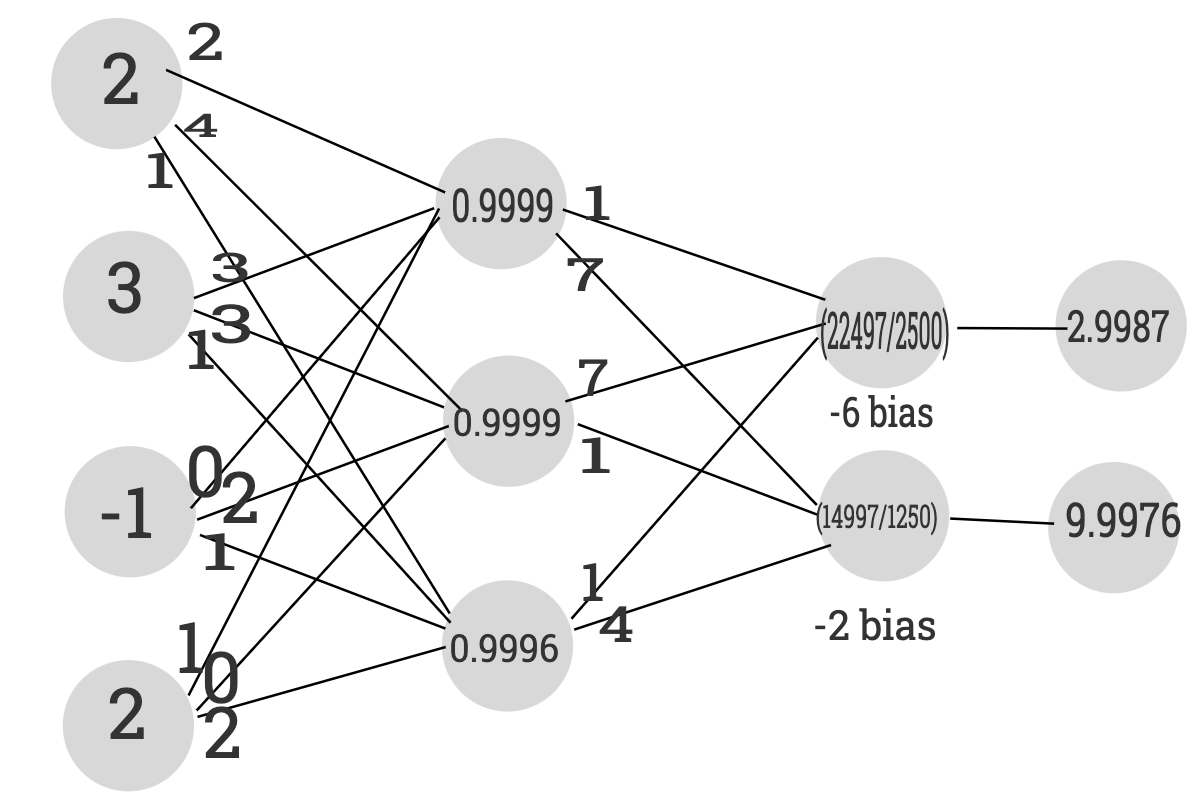

In [15]:
Image(filename='./grafoDirigido.PNG')

# Ejercicio 5: [20 puntos] [no usar `MLPClassifier`] Para la Tabla de Datos que se muestra seguidamente donde $x^j$ para $j = 1, 2, 3$ son las variables predictoras y la variable a predecir es `z` diseñe y programe a pie una Red Neuronal de una capa (Perceptron):

 

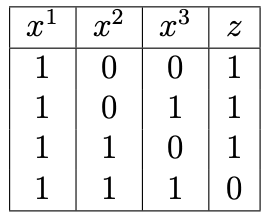

In [218]:

Image(filename='./tabla.PNG')

Es decir, encuentre todos los posibles pesos $w_1, w_2, w_3$ y umbrales θ para la Red Neuronal que se muestra en el siguiente gráfico:

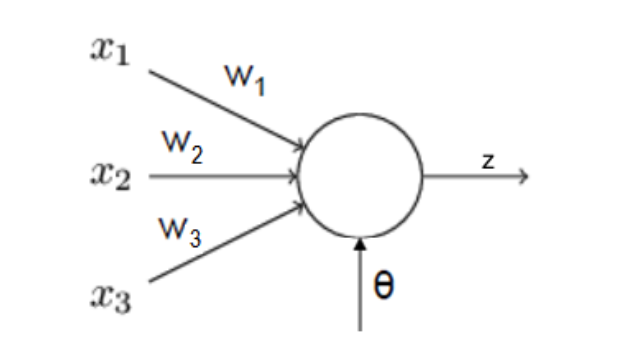

In [219]:
Image(filename='./neurona.PNG')

Use una función de activación tipo tanh(x), es decir:

$$f(x) = \tanh(x) = \dfrac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

Para esto escriba una Clase en `Python` que incluya los métodos necesarios pra implementar esta Red Neuronal.
Se deben hacer variar los pesos $w_j$ con $j = 1,2,3$ en los siguientes valores `v=(-1,-0.9,-0.8,...,0,...,0.8,0.9,1)` y haga variar θ en `u=(0,0.1,...,0.8,0.9,1)`. Escoja los pesos $w_j$ con $j = 1, 2, 3$ y el umbral θ de manera que se minimiza el error cuadrático medio:

$$E(w_1,w_2,w_3) = \dfrac{1}{4} \sum_{i=1}^{4}\Big[ I\Big[ f\Big(\sum_{j=1}^{3}w_j \cdot x_{i}^{j} - θ \Big)\Big] - z_i\Big]^2 $$

donde $x_i^j$ es la entrada en la fila $i$ de la variable $x^j$ e $I(z)$ se define como sigue:

$$ I(t) = 
  \begin{cases}
            1 & \text{si $t \geq 0$} \\
            0 & \text{si $t < 0$}
  \end{cases} $$

In [282]:
d = {'x1' : [1,1,1,1],'x2' : [0,0,1,1],'x3' : [0,1,0,1] ,'z' : [1,1,1,0]}

df = pd.DataFrame(d)
df

,x1,x2,x3,z
0,1,0,0,1
1,1,0,1,1
2,1,1,0,1
3,1,1,1,0


In [283]:
#función de activación
def tanh(x):
    y = (math.exp(x)-math.exp(-x))/(math.exp(x) + math.exp(-x))
    return y

In [284]:
def I(t):
    if(t>=0):
        return(1)
    else:
        return(0)

In [285]:
#Pesos
v = np.linspace(start=-1, stop=1, num=21)
u = np.linspace(start=0, stop=1, num=11)

In [286]:
error = pd.DataFrame(columns = ['w1', 'w2', 'w3','omega','Error'])


for omega in u:
    for w1 in v:
        for w2 in v:
            for w3 in v:
                s=0
                for i in range(1,4):
                    s = s + (I(tanh(w1*df.iloc[i,0] - omega +w2*df.iloc[i,1]-omega + w3*df.iloc[i,2]-omega))-df.iloc[i,3])**2
                error = error.append({'w1':w1, 'w2':w2, 'w3':w3,'omega':omega,'Error':s/4},
                                     ignore_index = True)
                

                

Pesos y umbral que minimizan el error

In [290]:
error[error.Error == 0]



,w1,w2,w3,omega,Error
5049,0.1,-0.1,-0.1,0.0,0.0
5468,0.2,-0.2,-0.2,0.0,0.0
5469,0.2,-0.2,-0.1,0.0,0.0
5489,0.2,-0.1,-0.2,0.0,0.0
5887,0.3,-0.3,-0.3,0.0,0.0
...,...,...,...,...,...
27496,1.0,-0.3,-0.3,0.2,0.0
27497,1.0,-0.3,-0.2,0.2,0.0
27516,1.0,-0.2,-0.4,0.2,0.0
27517,1.0,-0.2,-0.3,0.2,0.0
